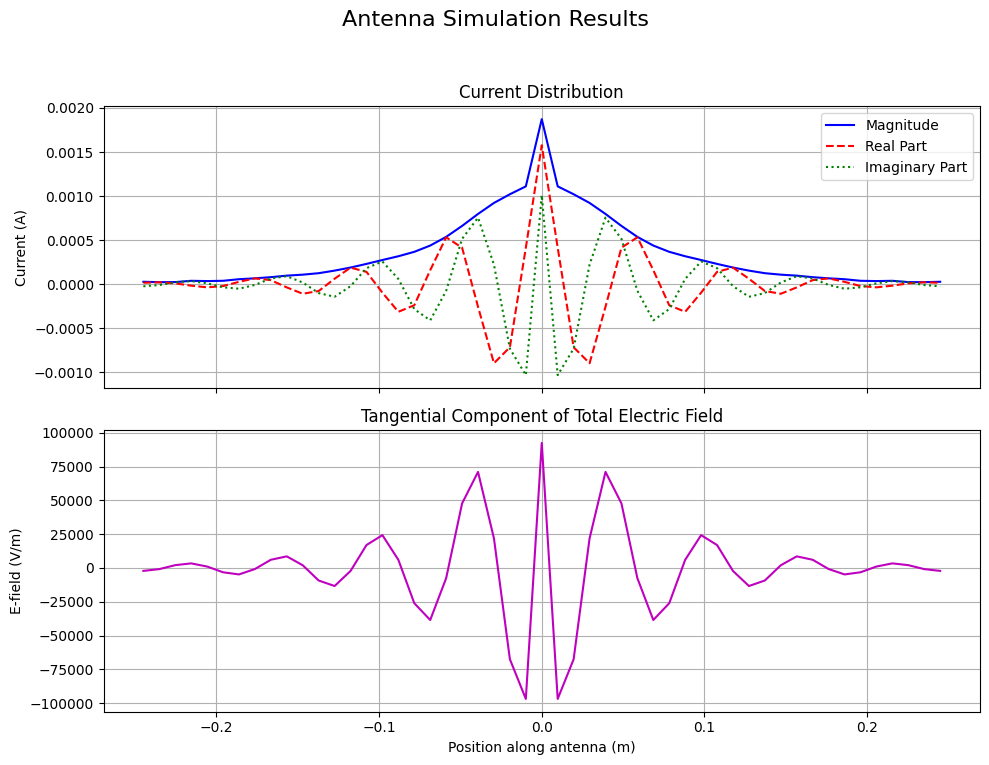

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, mu_0, c

def simulate_antenna(frequency, length, radius, num_segments):
    """
    Simulates a direct wired antenna using PWS basis functions and Point Matching.

    Args:
        frequency (float): The frequency of operation in Hz.
        length (float): The length of the antenna in meters.
        radius (float): The radius of the antenna wire in meters.
        num_segments (int): The number of segments to divide the antenna into.

    Returns:
        tuple: A tuple containing:
            - z_points (numpy.ndarray): The z-coordinates of the segment midpoints.
            - I (numpy.ndarray): The complex current distribution on the antenna.
            - Et (numpy.ndarray): The tangential component of the total electric field.
    """

    # 1. Constants and Parameters
    wavelength = c / frequency
    k = 2 * np.pi / wavelength  # Wavenumber
    segment_length = length / num_segments
    z_points = np.linspace(-length / 2 + segment_length / 2, length / 2 - segment_length / 2, num_segments)

    # 2. Impedance Matrix (Z)
    Z = np.zeros((num_segments, num_segments), dtype=complex)

    for m in range(num_segments):
        for n in range(num_segments):
            if m == n:
                # Self-impedance term
                Z[m, n] = (1j * k * segment_length / (2 * np.pi * epsilon_0 * c)) * \
                          (1 - 1j / (k * segment_length)) * np.log(segment_length / radius)
            else:
                # Mutual-impedance term
                R = np.sqrt((z_points[m] - z_points[n])**2 + radius**2)
                Z[m, n] = (1j * k * segment_length / (2 * np.pi * epsilon_0 * c)) * \
                          (np.exp(-1j * k * R) / R)

    # 3. Excitation Vector (V)
    V = np.zeros(num_segments, dtype=complex)
    # Excite the center segment
    center_segment = num_segments // 2
    V[center_segment] = 1.0  # 1 Volt excitation

    # 4. Solve for Current (I)
    I = np.linalg.solve(Z, V)

    # 5. Calculate Tangential Electric Field (Et)
    Et = np.zeros(num_segments, dtype=complex)
    for m in range(num_segments):
        for n in range(num_segments):
            R = np.sqrt((z_points[m] - z_points[n])**2 + radius**2)
            # Contribution from each current segment
            Et[m] += I[n] * (1j * k * segment_length / (2 * np.pi * epsilon_0 * c)) * \
                     (np.exp(-1j * k * R) / R) * \
                     (1 + (1j / (k * R)) - (1 / (k**2 * R**2)))

    return z_points, I, np.real(Et)

if __name__ == '__main__':
    # --- Simulation Parameters ---
    frequency = 300e6  # 300 MHz
    wavelength = c / frequency
    antenna_length = wavelength / 2  # Half-wave dipole
    wire_radius = 0.001 * wavelength # One thousandth of a wavelength
    num_segments = 51  # Odd number for a center segment

    # --- Run Simulation ---
    z, current, E_tangential = simulate_antenna(frequency, antenna_length, wire_radius, num_segments)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle('Antenna Simulation Results', fontsize=16)

    # Plot Current Distribution
    ax1.plot(z, np.abs(current), 'b-', label='Magnitude')
    ax1.plot(z, np.real(current), 'r--', label='Real Part')
    ax1.plot(z, np.imag(current), 'g:', label='Imaginary Part')
    ax1.set_ylabel('Current (A)')
    ax1.set_title('Current Distribution')
    ax1.grid(True)
    ax1.legend()

    # Plot Tangential Electric Field
    ax2.plot(z, E_tangential, 'm-')
    ax2.set_xlabel('Position along antenna (m)')
    ax2.set_ylabel('E-field (V/m)')
    ax2.set_title('Tangential Component of Total Electric Field')
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()